# AML — Task 1
## Predict the age of a brain from MRI features
---

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from pandas_profiling import ProfileReport

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.neighbors import LocalOutlierFactor

---
## Function definition

---
### Load datasets

In [3]:
def load_raw_data():
    X_train = pd.read_csv('data/X_train.csv').drop(columns=['id'])
    y_train = pd.read_csv('data/y_train.csv').drop(columns=['id'])
    X_test = pd.read_csv('data/X_test.csv').drop(columns=['id'])
    return X_train, y_train, X_test

---
### Export datasets

In [4]:
def export_to_csv(X_train_cleaned, y_train_cleaned, X_test_cleaned):
    X_train_cleaned.to_csv('data/X_train_cleaned.csv', index=False)
    y_train_cleaned.to_csv('data/y_train_cleaned.csv', index=False)
    X_test_cleaned.to_csv('data/X_test_cleaned.csv', index=False)

---
### Outlier detection

In [5]:
def remove_outliers(X_train, y_train, contamination='auto', verbose=1):
    """
    Remove the ouliers from our dataset. Temporarily replace the nan values by 
    the median to perform the outlier detection.

    Parameters
    ----------
    X_train : pd.df
        The features (what we will use to see the outliers)
    y_train : pd.df
        The labels
    contamination : int, optional
        The percent of outliers found by the isolation forest if it is used.

    Return
    ------
    (pd.df, pd.df)
        The data with the outliers rows removed
    """
    # Save a mask of the imputed values to be able to redo the imputation once the outlier detection is done
    X_train_null_mask = X_train.isna()
    
    # Need to impute nan values for the outlier detection to work (cannot deal with nan)
    X_train_imputed = pd.DataFrame(SimpleImputer(strategy="median", verbose=verbose).fit_transform(X_train))
    
#     clf = IsolationForest(contamination=contamination, random_state=0) # modify here
    clf = LocalOutlierFactor(contamination=contamination) # modify here
    outliers_mask = pd.Series(clf.fit_predict(X_train_imputed))
    
    if verbose:
        print(f"Detected {(outliers_mask == -1).sum()} outliers, out of {outliers_mask.shape[0]} samples ({100 * (outliers_mask == -1).sum() / outliers_mask.shape[0]:.2f}%).")
    
    # Put back the nan values
    # convert the null mask to np.array so it is correctly applied since X_train indexes have changed
    X_train_no_outliers = X_train_imputed.mask(np.array(X_train_null_mask))
    
    # Remove outliers from the training set
    X_train_no_outliers = X_train_no_outliers.loc[outliers_mask == 1, :]
    y_train_no_outliers = y_train.loc[outliers_mask == 1, :]
    
    return (X_train_no_outliers, y_train_no_outliers)

---
### Data scaling
Should be done as soon as possible because can have an effect (e.g. on distances for `KNNImputer`)

In [6]:
def scale(X_train, X_test):
    # Do the scaling, saving the scaler to use it for X_test too. No need for imputation, just ignore nan values.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train))
    # Cast X_test to np.array to avoid warning of model trained without feature names but X having some.
    X_test_scaled = pd.DataFrame(scaler.transform(np.array(X_test)))
    return (X_train_scaled, X_test_scaled)

---
### Imputation of values

In [7]:
def impute_values(X_train, X_test):
    print(f"For the train dataset, there are {np.array(X_train_scaled.isna()).sum().sum()} nan values, out of {X_train_scaled.shape[0]*X_train_scaled.shape[1]} ({100*np.array(X_train_scaled.isna()).sum().sum()/(X_train_scaled.shape[0]*X_train_scaled.shape[1]):.2f}%).")
    
    imputer = KNNImputer(n_neighbors=6, weights='uniform').fit(X_train) # modify here
    # Runs VERY slowly (i.e. did 1/10 of the job in 6 minutes...), need to tweak parameters
#     imputer = IterativeImputer(random_state=0, verbose=2).fit(X_train) # modify here
    
    X_train_imputed = pd.DataFrame(imputer.transform(X_train))
    X_test_imputed = pd.DataFrame(imputer.transform(X_test))
    return (X_train_imputed, X_test_imputed)

---
### Feature selection

In [8]:
def select_features(X_train, y_train, X_test):
    X_train_selected_features, X_test_selected_features = remove_constant_features(X_train, X_test)
    X_train_selected_features, X_test_selected_features = remove_too_correlated_features(X_train_selected_features, X_test_selected_features)
    X_train_selected_features, X_test_selected_features = remove_random_features(X_train_selected_features, y_train, X_test_selected_features)
    
    return X_train_selected_features, X_test_selected_features

In [9]:
def remove_constant_features(X_train, X_test, verbose=1):
    X_train_selected_features = X_train.loc[:, (X_train != X_train.iloc[0]).any()]
    X_test_selected_features = X_test.loc[:, (X_train != X_train.iloc[0]).any()]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of constant values ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%)")
    
    return X_train_selected_features, X_test_selected_features

In [10]:
def remove_too_correlated_features(X_train, X_test, threshold=0.8, verbose=1):
    X_train_corr_ = X_train.corr()

    X_train_too_correlated = (X_train_corr_.mask(
        np.tril(np.ones([len(X_train_corr_)]*2, dtype=bool))).abs() > threshold).any()
    
    X_train_selected_features = X_train.loc[:, (~X_train_too_correlated)]
    X_test_selected_features = X_test.loc[:, (~X_train_too_correlated)]
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of correlation > {threshold} ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%)")

    return X_train_selected_features, X_test_selected_features

In [11]:
def remove_random_features(X_train, y_train, X_test, verbose=1):
    selector = SelectPercentile(f_regression, percentile=80) # modify here
    selector.fit(X_train, np.array(y_train).ravel())
    X_train_selected_features = pd.DataFrame(selector.transform(X_train))
    X_test_selected_features = pd.DataFrame(selector.transform(X_test))
    
    if verbose:
        print(f"{X_train.shape[1]-X_train_selected_features.shape[1]} features removed because of low correlation with target ({100*(X_train.shape[1]-X_train_selected_features.shape[1])/X_train.shape[1]:.2f}%)")
        
    return X_train_selected_features, X_test_selected_features

---
### Models

In [12]:
def best_lasso(X_train, y_train):
    lasso = Lasso(max_iter=100000)
    gs_lasso_params = {
        'alpha': np.logspace(-1, 0, 20),
    }
    gs_lasso = GridSearchCV(lasso, gs_lasso_params, cv=5, verbose=3)
    gs_lasso.fit(X_train, y_train)
    
    print(f"The best validation score obtained is {gs_lasso.best_score_:.5f} with\n\talpha: {gs_lasso.best_params_['alpha']}")
    
    return gs_lasso

In [13]:
def best_svr(X_train, y_train):
    svr = SVR()
    gs_svr_params = {
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'C': np.logspace(-1, 2.2, 4),
        'epsilon': np.logspace(-2, 1, 3),
    }
    gs_svr = GridSearchCV(svr, gs_svr_params, cv=5, verbose=3)
    gs_svr.fit(X_train, y_train)
    
    print(f"""The best validation score obtained is {gs_svr.best_score_:.5f} with
    \tkernel: {gs_svr.best_params_['kernel']}
    \tC: {gs_svr.best_params_['C']}
    \tepsilon: {gs_svr.best_params_['epsilon']}""")
    
    return gs_svr

In [62]:
def best_gbr(X_train, y_train):
#     gbr = GradientBoostingRegressor(random_state=0)
#     gs_gbr_params = {
#         "learning_rate": np.logspace(-3, -1, 3),
#         "n_estimators": np.logspace(1, 3, 3),
#         "subsample": [0.7, 1],
#         "max_depth": [3, 4, 5],
#     }
#     gs_gbr = GridSearchCV(gbr, gs_gbr_params, cv=5, verbose=3, error_score='raise')
#     gs_gbr.fit(X_train, y_train)
#     return gs_gbr

    params = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
        "random_state": 0, 
        "verbose": 2,
    }

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    gbr = GradientBoostingRegressor(**params)
    gbr.fit(X_train, y_train)
    
    print(f"Score is {gbr.score(X_test, y_test):.4f}.")
    
    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(gbr.staged_predict(X_test)):
        test_score[i] = gbr.loss_(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(params["n_estimators"]) + 1,
        gbr.train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
        np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()
    
    return gbr

---
### Submission file

In [17]:
def create_submission(prediction, sub_id, basepath='submissions/task1-sub'):
    result = prediction.copy()
    result = result.rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

---
## Run pipeline

---
### Data preprocessing

In [19]:
print("Loading raw data...")
X_train, y_train, X_test = load_raw_data()

print("Removing outliers...")
X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train)

print("Scaling data...")
X_train_scaled, X_test_scaled = scale(X_train_no_outliers, X_test)

print("Imputing nan values...")
X_train_imputed, X_test_imputed = impute_values(X_train_scaled, X_test_scaled)

print("Selecting features...")
X_train_selected_features, X_test_selected_features = select_features(X_train_imputed, y_train_no_outliers, X_test_imputed)

print("Exporting clean data to csv...")
X_train_cleaned, y_train_cleaned, X_test_cleaned = X_train_selected_features, y_train_no_outliers, X_test_selected_features
export_to_csv(X_train_cleaned, y_train_cleaned, X_test_cleaned)

print("All done!")

Loading raw data...
Removing outliers...
Detected 50 outliers, out of 1212 samples (4.13%).
Scaling data...
Imputing nan values...
For the train dataset, there are 73743 nan values, out of 966784 (7.63%).
Selecting features...
4 features removed because of constant values (0.48%)
87 features removed because of correlation > 0.8 (10.51%)
149 features removed because of low correlation with target (20.11%)
Exporting clean data to csv...
All done!


---
### Model training

In [ ]:
lasso = best_lasso(X_train_cleaned, y_train_cleaned)

In [ ]:
svr = best_svr(X_train_cleaned, np.array(y_train_cleaned).ravel())

      Iter       Train Loss   Remaining Time 
         1          96.1602            1.30m
         2          95.1053            1.29m
         3          94.0713            1.27m
         4          93.0620            1.26m
         5          92.0668            1.26m
         6          91.0684            1.25m
         7          90.0973            1.25m
         8          89.1688            1.28m
         9          88.2340            1.27m
        10          87.3144            1.27m
        11          86.3989            1.26m
        12          85.5015            1.26m
        13          84.6056            1.25m
        14          83.7414            1.25m
        15          82.8941            1.25m
        16          82.0438            1.25m
        17          81.2263            1.24m
        18          80.4096            1.24m
        19          79.6227            1.24m
        20          78.8357            1.23m
        21          78.0527            1.23m
        2

       183          24.1945           49.84s
       184          24.0719           49.67s
       185          23.9524           49.51s
       186          23.8374           49.35s
       187          23.7352           49.20s
       188          23.6220           49.03s
       189          23.5073           48.87s
       190          23.3969           48.71s
       191          23.2875           48.55s
       192          23.1649           48.38s
       193          23.0638           48.21s
       194          22.9348           48.04s
       195          22.8262           47.88s
       196          22.7087           47.72s
       197          22.6157           47.56s
       198          22.5091           47.39s
       199          22.4075           47.24s
       200          22.3037           47.08s
       201          22.1957           46.92s
       202          22.1026           46.75s
       203          22.0025           46.59s
       204          21.8857           46.42s
       205

       367          11.1741           20.75s
       368          11.1334           20.59s
       369          11.1106           20.44s
       370          11.0875           20.29s
       371          11.0579           20.13s
       372          11.0158           19.98s
       373          10.9768           19.82s
       374          10.9448           19.67s
       375          10.9027           19.51s
       376          10.8647           19.35s
       377          10.8148           19.20s
       378          10.7931           19.04s
       379          10.7722           18.89s
       380          10.7441           18.73s
       381          10.7015           18.58s
       382          10.6643           18.42s
       383          10.6237           18.26s
       384          10.5954           18.11s
       385          10.5605           17.95s
       386          10.5397           17.80s
       387          10.5056           17.64s
       388          10.4611           17.49s
       389

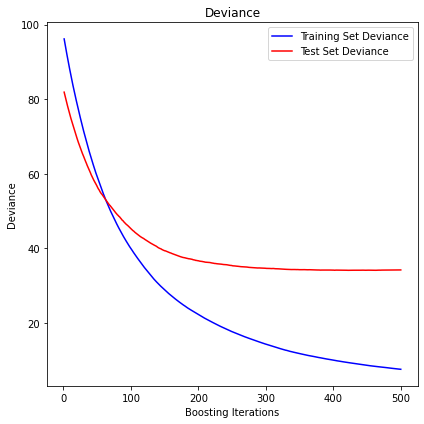

In [63]:
gbr = best_gbr(X_train_cleaned, np.array(y_train_cleaned).ravel())

---
### Creation of the submission file

In [64]:
prediction = pd.DataFrame(gbr.predict(X_test_selected_features)) # modify here
sub_id = 8 # modify here
create_submission(prediction, sub_id)

Link where to submit: https://aml.ise.inf.ethz.ch/task1/#submission